# RNN

# 1. Spam 예측

In [1]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile

In [15]:
epochs = 20
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_fequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32) #학습 동안은 0.5, 평가는 1.0

# Start a graph
sess = tf.Session()

In [3]:
# Download or open data
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')

    # Save data to text file
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x)>=1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [4]:
# Create a text cleaning function
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return(text_string)

# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]

In [16]:
# 텐서 플로 내정 어휘 함수로 문자 데이터 처리하고, 색인 얻기
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length, min_frequency=min_word_fequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

In [17]:
#scikit-learn 패키지 model_selection.train_test_spilt()가 더 나음.
# Shuffle and split data
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x=='ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

# Split train/test set
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 933
80-20 Train Test split: 4459 -- 1115


In [18]:
# 그래프 및 플레이스 홀더 선언, 문자 메세지의 최대 단어 길이에 따라 달라지므로, X는 [None, max_seq_length], y는 0 or 1
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

#임베딩 행렬 생성 및 입력 데이터 x에 대한 임베딩 값 조절
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data) # shape=(?, 25, 50)

In [19]:
# 크기가 10인 RNN셀 형식을 초기화 후, RNN을 동적으로 선언하여 연속 RNN만든다 + 드랍아웃 추가
#동적 RNN은 길이가 가변인 연속 데이터 허용
cell = tf.contrib.rnn.BasicLSTMCell(num_units = rnn_size)
output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

In [20]:
#예측 결과를 위해서 RNN결과 재배열 및 마지막 출력 잘라내기
output = tf.transpose(output, [1,0,2]) #shape=(25, ?, 10) 
last = tf.gather(output, int(output.get_shape()[0]) - 1) #shape=(?, 10)

In [21]:
#RNN예측 마무리를 위한 rnn_size출력 값을 완전 연결 계층을 통한 이진 분류 결과 변환
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1)) #shape=(10, 2)
bias = tf.Variable(tf.constant(0.1, shape=[2])) # shape=(2,)
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias) # shape=(?, 2)

#다음 비용 함수 선언. sparse_softmax 함수 사용 시, 정수 색인 값과 실수형 logits 값이 필요
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits_out, labels=y_output) #logits=float32, labels =int32
loss = tf.reduce_mean(losses)

#테스트 셋과 학습셋에 대한 알고리즘 성능 비교를 위한 정확도 함수
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))
#tf.cast역할: tf.cast로 입력 값을 부동 소수점 값으로 변경 및, T,F로 채워진 prediction 텐서의 값을 숫자로 변환

In [22]:
#최적화 함수 생성 및 모델 변수 초기화
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

/Users/naver/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [23]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
# Start training
for epoch in range(epochs):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        # Run train step
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
        
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # Run Eval Step
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoch: 1, Test Loss: 0.64, Test Acc: 0.98
Epoch: 2, Test Loss: 0.59, Test Acc: 0.99
Epoch: 3, Test Loss: 0.55, Test Acc: 1.0
Epoch: 4, Test Loss: 0.51, Test Acc: 1.0
Epoch: 5, Test Loss: 0.48, Test Acc: 1.0
Epoch: 6, Test Loss: 0.46, Test Acc: 1.0
Epoch: 7, Test Loss: 0.43, Test Acc: 1.0
Epoch: 8, Test Loss: 0.41, Test Acc: 1.0
Epoch: 9, Test Loss: 0.4, Test Acc: 1.0
Epoch: 10, Test Loss: 0.39, Test Acc: 1.0
Epoch: 11, Test Loss: 0.38, Test Acc: 1.0
Epoch: 12, Test Loss: 0.37, Test Acc: 1.0
Epoch: 13, Test Loss: 0.36, Test Acc: 1.0
Epoch: 14, Test Loss: 0.35, Test Acc: 1.0
Epoch: 15, Test Loss: 0.35, Test Acc: 1.0
Epoch: 16, Test Loss: 0.35, Test Acc: 1.0
Epoch: 17, Test Loss: 0.34, Test Acc: 1.0
Epoch: 18, Test Loss: 0.34, Test Acc: 1.0
Epoch: 19, Test Loss: 0.34, Test Acc: 1.0
Epoch: 20, Test Loss: 0.34, Test Acc: 1.0


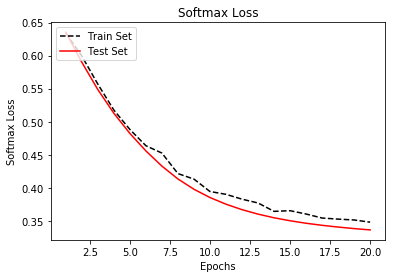

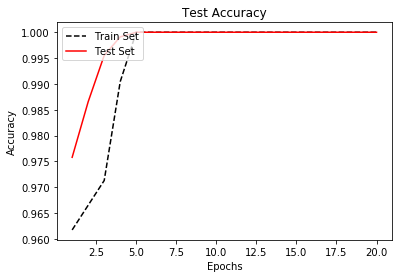

In [24]:
# Plot loss over time
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [14]:
import functions
functions.showConstant(embedding_output)

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]

Caused by op 'Variable/read', defined at:
  File "/Users/naver/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/naver/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/naver/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/naver/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/naver/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/naver/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/naver/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/naver/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-cde917dde733>", line 6, in <module>
    embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
  File "/Users/naver/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 330, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/naver/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1400, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/naver/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]


In [ ]:
getLength(t)
showConstant(t)
showConstantDetail(t):
showVariable(v):
var2Numpy(v):
op2Numpy(op):
showOperation(op):